In [2]:
import antarctic_plots
import pygmt
import numpy as np
import pandas as pd
import numpy as np
from scipy import stats
import geopandas as gpd
import xarray as xr
import rioxarray
import verde as vd
import harmonica as hm
import pooch
from pyproj import Transformer
import os
os.getcwd()

'c:\\Users\\matthewt\\Documents\\Python_Scripts\\RIS_gravity_inversion'

# Plotting Function

In [2]:
# make function for a starting point for RIS plots
# default map extent is for Ross Ice Shelf
def start_fig(n = -1600e3, e = -860e3, s = -200e3, w = 670e3, 
    data_region=False, 
    coordinates=None, 
    subplots=False):
    
    global fig, fig_reg, fig_proj, fig_proj_ll, bardwidth, pos_str
    
    if data_region==True:
        region = vd.get_region(coordinates)
        e,w,n,s = region[0], region[1], region[2], region[3]
        e-=10e3
        w+=10e3
        n-=10e3
        s+=10e3
    #set figure height, width and map scale
    fig_height = 180 # in mm
    fig_width = fig_height*(w-e)/(s-n)
    fig_ratio = (s-n)/(fig_height/1000)

    # Make a GMT region string and projection strings in both ESPG3031 and Lat/Lon
    fig_reg = f'{e}/{w}/{n}/{s}'
    fig_proj = f"x1:{fig_ratio}"
    fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"

    # colorbar width and position
    barwidth = fig_width/10 * 0.8 # color bar width is 40% of the map width, in cm
    pos_str = f'jBC+w{barwidth}c/.5c+jTC+o0c/.2c+h+e'
    
    # initialize figure
    if subplots==False:
        fig = pygmt.Figure()
    # if adding a suplot, don't re-initialize, but move origin over    
    else:
        fig.shift_origin(xshift=fig_width/10)
    
    # plot graticules overtop, at 4d latitude and 30d longitude
    with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black', 
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90', ):
        fig.basemap(region = fig_reg, projection = fig_proj_ll, frame = ["NSWE", "xa30g15", "ya4g2"], verbose='e')
    fig.basemap(region = fig_reg, projection = fig_proj, 
            frame = ["nwse", "xf100000", "yf100000", "g0"],verbose='e')
start_fig()

# ROSETTA-Ice data

## load data
with Pooch, checking the hash key to confirm it's the same downloaded file

In [3]:
file_path = pooch.retrieve(
    # URL to one of Pooch's test files
    url="http://wonder.ldeo.columbia.edu/data/ROSETTA-Ice/Gravity/rs_2019_grav.csv",
    known_hash='d4fdfcc293ac13e6222938bfa9e1e9ccc781ea7556a13d356e9f1b4aba809928',
    )
    # height is above WGS84 ellipsoid
rosetta = pd.read_csv(file_path)
# center grav data on 0
rosetta['FAG_levelled'] -= rosetta.FAG_levelled.mean()

# maxabs = vd.maxabs(rosetta.FAG_levelled)*.5
# pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs])  
# start_fig(data_region=True, coordinates=(rosetta.x, rosetta.y))
# fig.plot(x=rosetta.x, 
#          y=rosetta.y, 
#          color=rosetta.FAG_levelled,
#          style='c4p',
#          projection = fig_proj,
#          region=fig_reg, 
#          cmap=True)
# fig.colorbar(frame='af+l"free air gravity [mGal]"')
# fig.show()

rosetta.FAG_levelled.hist(bins=100)
rosetta.describe()

LATITUDE      LONGITUDE      unixtime         Height  \
count  398279.000000  398279.000000  3.982790e+05  398279.000000   
mean      -80.571198     -36.741857  1.457515e+09     793.056619   
std         1.786949     165.241996  1.431469e+07      83.977581   
min       -85.389220    -179.999880  1.447367e+09     650.023000   
25%       -81.869075    -169.885715  1.448316e+09     744.524000   
50%       -80.392556    -158.359371  1.449134e+09     774.652000   
75%       -79.145016     171.037900  1.479949e+09     819.844000   
max       -77.339971     180.000724  1.480734e+09    1377.258000   

                   x             y  FAG_levelled  
count  398279.000000  3.982790e+05  3.982790e+05  
mean   -84278.810943 -1.000705e+06  4.329633e-15  
std    212966.781186  1.984653e+05  1.425479e+01  
min   -571781.809097 -1.367767e+06 -2.854953e+02  
25%   -240585.860838 -1.160510e+06 -7.364494e+00  
50%    -78622.827092 -1.010417e+06  2.097471e-01  
75%     80843.853800 -8.504463e+05  7.961177e+00  
max    371757.426732 -4.604543e+05  7.619118e+01

## block reduce
to avoid aliasing along flight lines

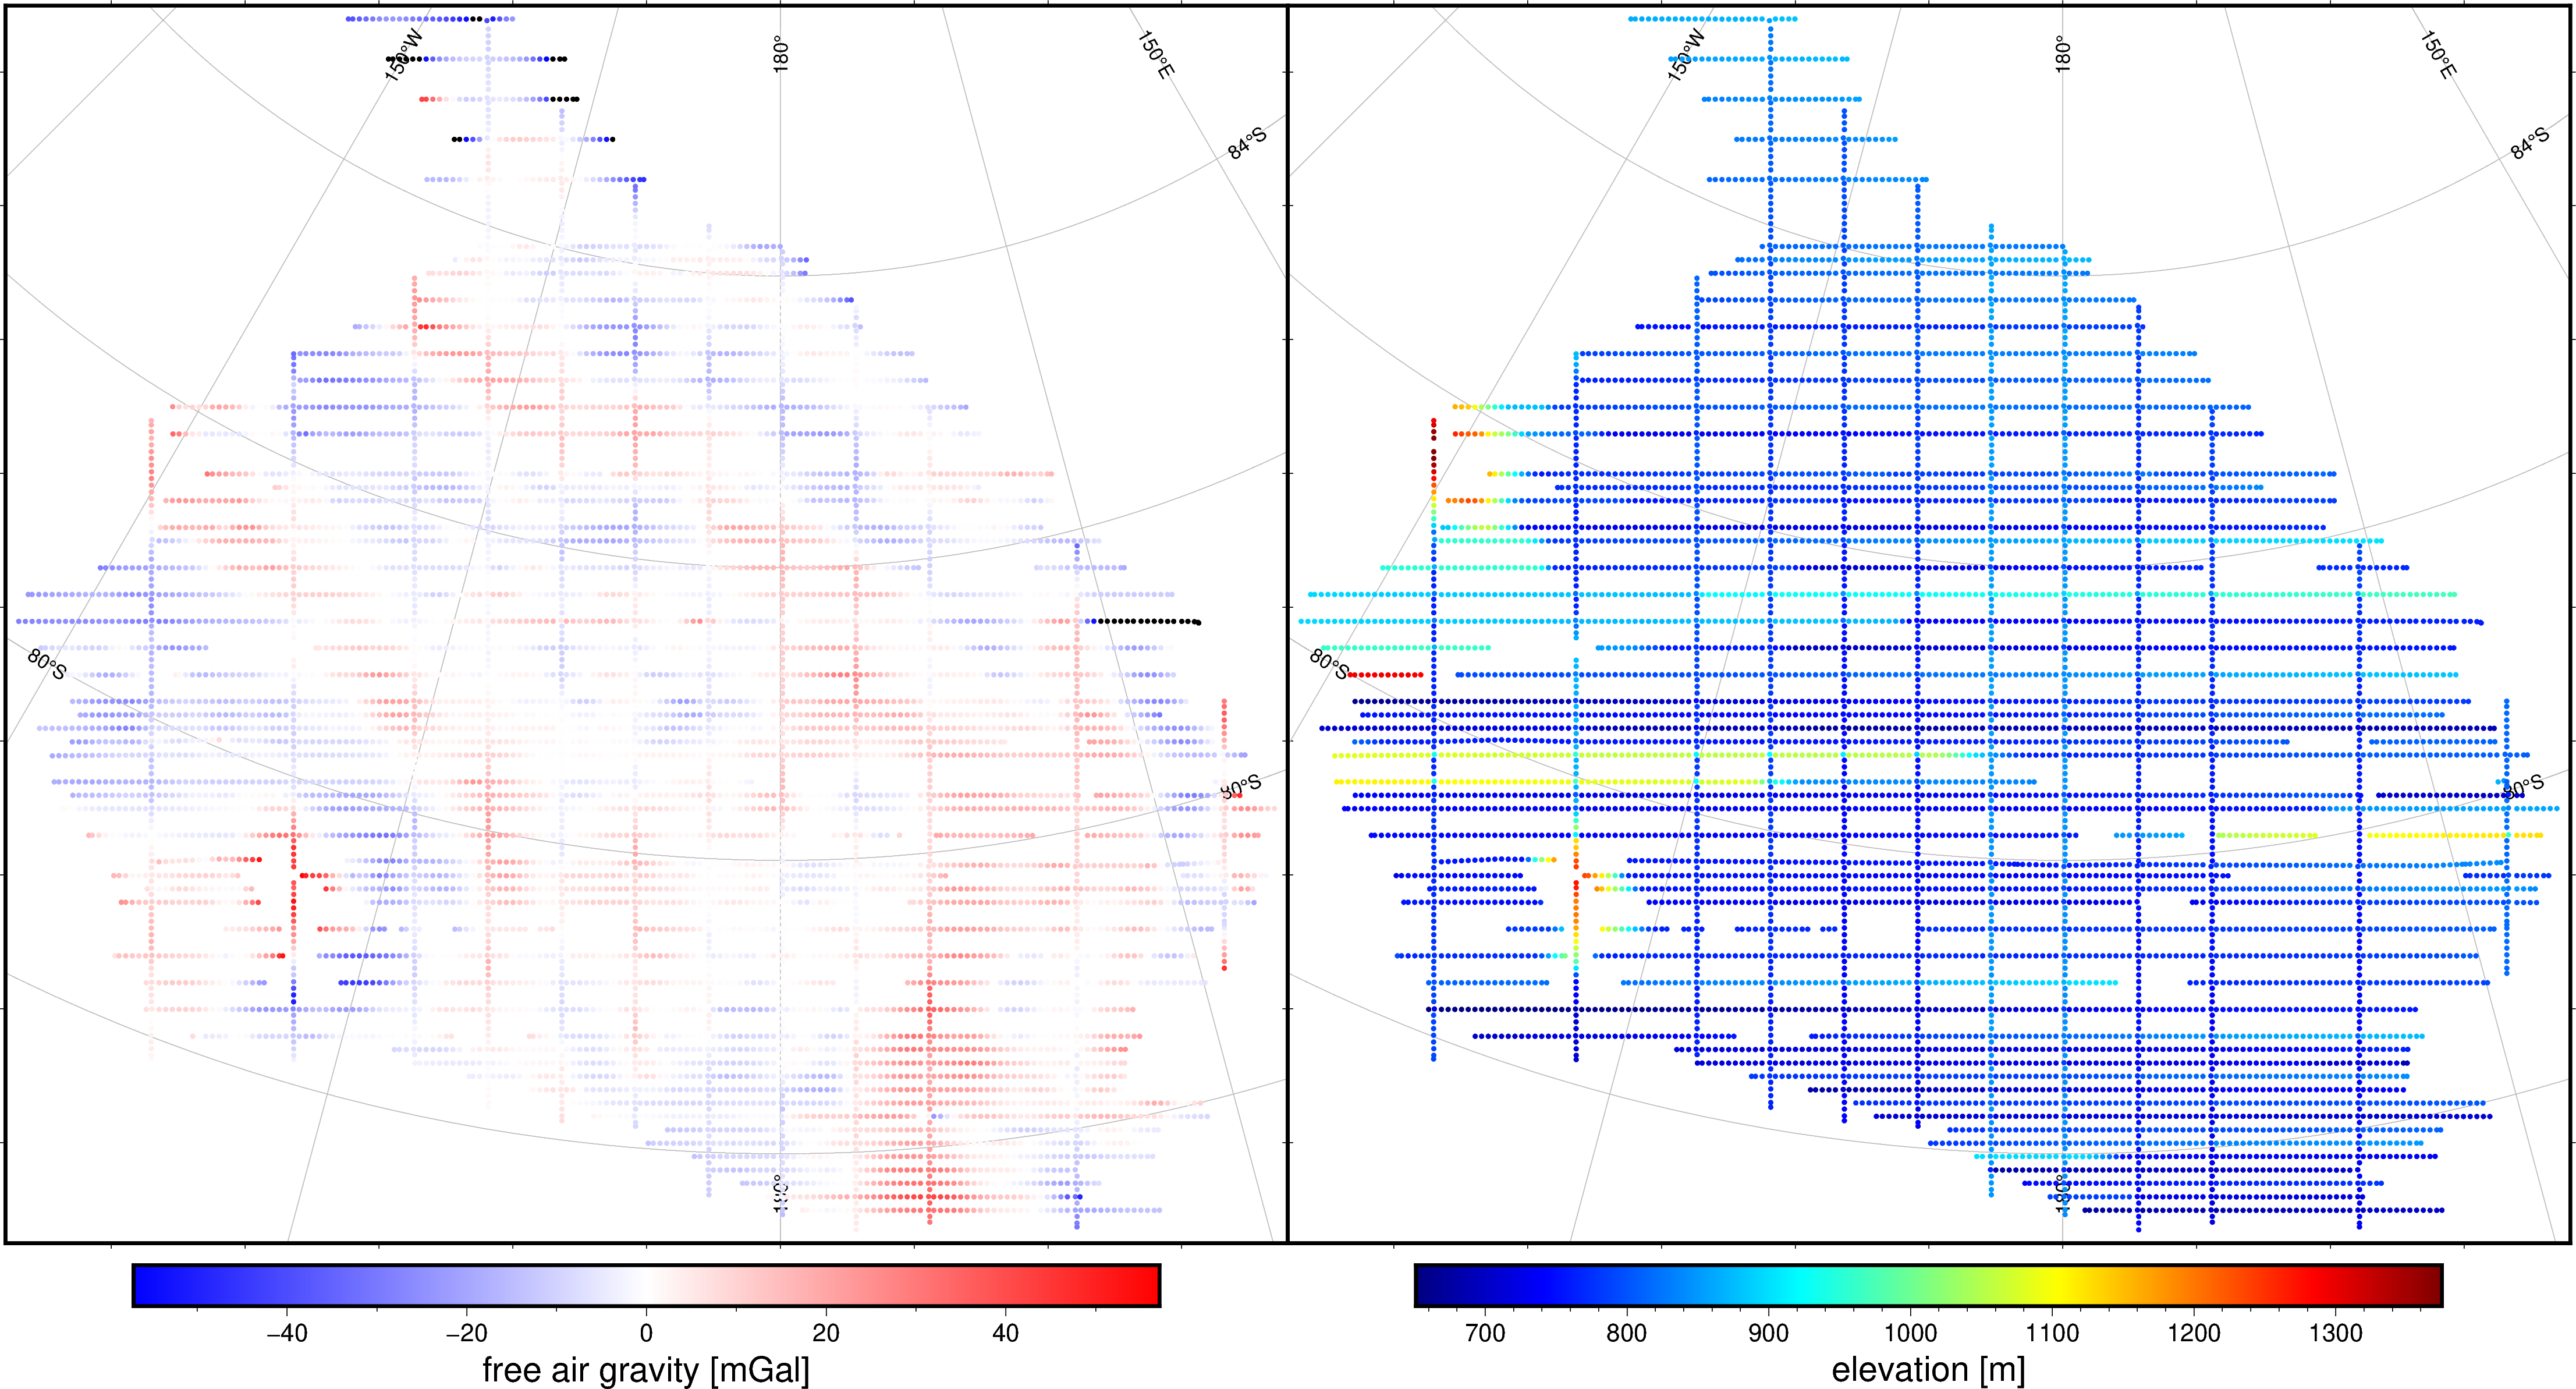

x             y  FAG_levelled         elev
count    7185.000000  7.185000e+03   7185.000000  7185.000000
mean   -85130.686232 -1.000598e+06     -0.174171   794.774991
std    216707.838680  1.982769e+05     14.977596    86.214410
min   -569306.933744 -1.365286e+06   -285.495163   651.087333
25%   -244809.099852 -1.160504e+06     -7.500035   745.215020
50%    -80040.915334 -1.010416e+06      0.199235   775.992293
75%     84696.668212 -8.504525e+05      7.868218   820.331627
max    369269.342582 -4.604571e+05     72.741864  1374.933457

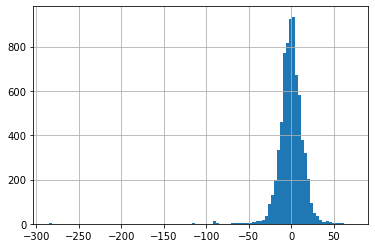

In [4]:
# reducer = vd.BlockReduce(reduction=np.mean, spacing=5000)
reducer_mean = vd.BlockReduce(reduction=np.mean, spacing=5000, center_coordinates=False)
coordinates, data = reducer_mean.filter(
    coordinates=(rosetta.x, rosetta.y), data=(rosetta.FAG_levelled, rosetta.Height))
df = pd.DataFrame(data={'x': coordinates[0], 'y':coordinates[1], 'FAG_levelled':data[0], 'elev':data[1]})

start_fig(data_region=True, coordinates=(df.x, df.y))
maxabs = vd.maxabs(df.FAG_levelled)*.2
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs])  
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FAG_levelled,
         style='c2p',
         cmap=True)
fig.colorbar(frame='af+l"free air gravity [mGal]"')
start_fig(data_region=True, coordinates=(df.x, df.y), subplots=True)
pygmt.makecpt(cmap="jet", series=[df.elev.min(), df.elev.max()])  
fig.plot(x=df.x, 
         y=df.y, 
         color=df.elev,
         style='c2p',
         cmap=True)

fig.colorbar(frame='af+l"elevation [m]"')
fig.show() 
df.FAG_levelled.hist(bins=100)
df.describe()

## remove outliers

                   x             y  FAG_levelled         elev       zscore
count    7185.000000  7.185000e+03   7185.000000  7185.000000  7185.000000
mean   -85130.686232 -1.000598e+06     -0.174171   794.774991     0.663194
std    216707.838680  1.982769e+05     14.977596    86.214410     0.748500
min   -569306.933744 -1.365286e+06   -285.495163   651.087333     0.000181
25%   -244809.099852 -1.160504e+06     -7.500035   745.215020     0.229606
50%    -80040.915334 -1.010416e+06      0.199235   775.992293     0.509822
75%     84696.668212 -8.504525e+05      7.868218   820.331627     0.903796
max    369269.342582 -4.604571e+05     72.741864  1374.933457    19.051178


<AxesSubplot:>

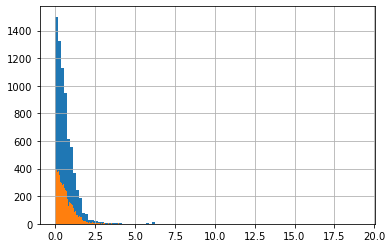

In [5]:
df['zscore']=np.abs(stats.zscore(df.FAG_levelled))
df.sort_values(by='zscore', ascending=False, inplace=True)
df.zscore.hist(bins=100)
print(df.describe())
# dropped base on z-score
df_cleaned=df[df.zscore < 5].copy()
df_outliers=df[df.zscore >= 5].copy()

# reset gravity at 0
df_cleaned['FAG_levelled'] -= df_cleaned.FAG_levelled.mean() 
df_cleaned.zscore.hist(bins=100)

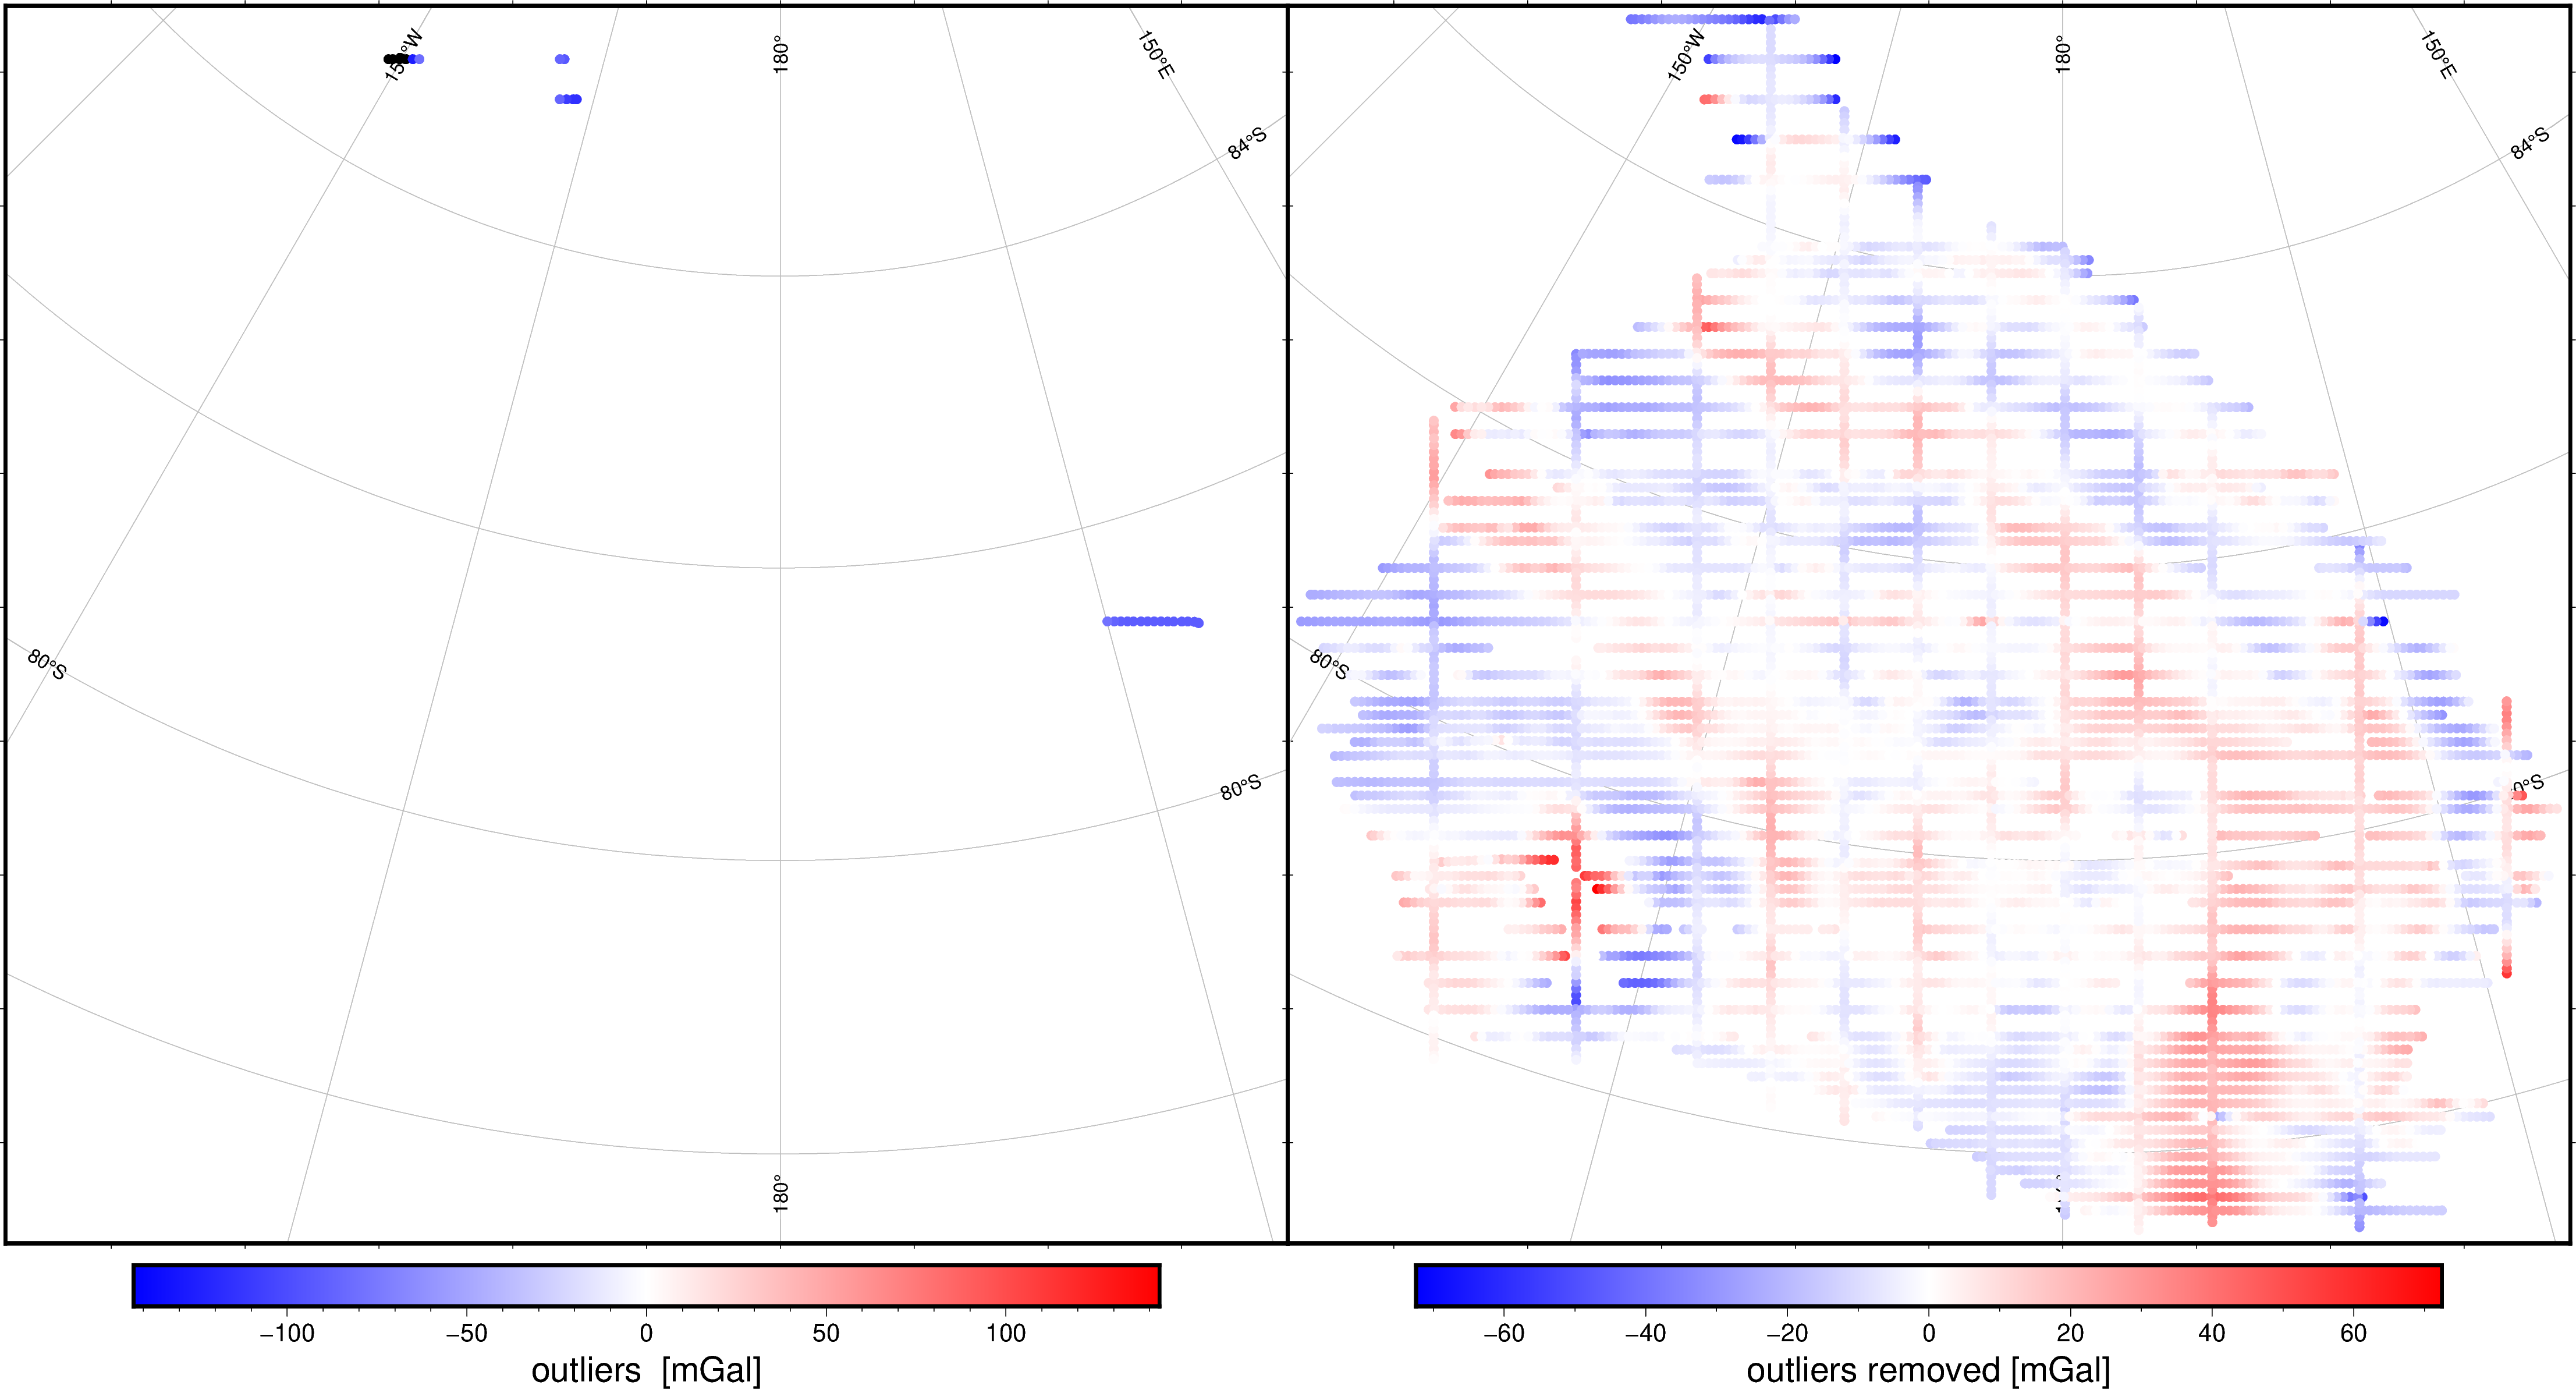

In [6]:
start_fig(data_region=True, coordinates=(df.x, df.y))
maxabs = vd.maxabs(df_outliers.FAG_levelled)*.5
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs])
fig.plot(x=df_outliers.x, 
         y=df_outliers.y, 
         color=df_outliers.FAG_levelled,
         style='c4p',
         cmap=True)
fig.colorbar(frame='af+l"outliers  [mGal]"')

start_fig(data_region=True, coordinates=(df.x, df.y), subplots=True)

maxabs = vd.maxabs(df_cleaned.FAG_levelled)
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs])
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=df_cleaned.FAG_levelled,
         style='c4p',
         cmap=True)
fig.colorbar(frame='af+l"outliers removed [mGal]"')
fig.show()

## create equivalent sources

In [7]:
coordinates = (df_cleaned.x, df_cleaned.y, df_cleaned.elev) 
eqs_first_guess = hm.EquivalentSources(
    depth=10e3, 
    block=5e3,
    # depth_type='constant', # make the depths constant, not relative to obs elev. # not conclusive for which is best in Soler and Uieda 2021
    damping=10) # high makes smoother predictions, lower can overfit / produce artifacts
eqs_first_guess.fit(coordinates, df_cleaned.FAG_levelled)

EquivalentSources(damping=10, depth=10000.0)

In [8]:
df_cleaned['first_guess_disturbance'] = eqs_first_guess.predict(coordinates)
df_cleaned.describe()

x             y  FAG_levelled         elev       zscore  \
count    7157.000000  7.157000e+03  7.157000e+03  7157.000000  7157.000000   
mean   -85722.459447 -1.001637e+06  9.530823e-17   794.737668     0.635298   
std    216349.448792  1.975562e+05  1.258551e+01    86.329743     0.550866   
min   -569306.933744 -1.365286e+06 -7.221830e+01   651.087333     0.000181   
25%   -244810.670570 -1.160506e+06 -7.685469e+00   745.069520     0.228957   
50%    -80045.124398 -1.010432e+06 -3.534268e-02   775.998528     0.507325   
75%     84686.305528 -8.504530e+05  7.622123e+00   820.235080     0.897971   
max    369269.342582 -4.604571e+05  7.245940e+01  1374.933457     4.868679   

       first_guess_disturbance  
count              7157.000000  
mean                  0.000070  
std                  12.498866  
min                 -69.597653  
25%                  -7.600618  
50%                  -0.027042  
75%                   7.618331  
max                  66.708382

In [9]:
score_first_guess = np.mean(
    vd.cross_val_score(
        eqs_first_guess,
        coordinates,
        df_cleaned.FAG_levelled,
    )
)
score_first_guess

0.9690121408449187

In [10]:
dampings = [0.01, 0.1, 1, 10,]
depths = [5e3, 10e3, 20e3, 50e3]

import itertools

parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))
print("Combinations:", parameter_sets)

Number of combinations: 16
Combinations: [{'damping': 0.01, 'depth': 5000.0}, {'damping': 0.01, 'depth': 10000.0}, {'damping': 0.01, 'depth': 20000.0}, {'damping': 0.01, 'depth': 50000.0}, {'damping': 0.1, 'depth': 5000.0}, {'damping': 0.1, 'depth': 10000.0}, {'damping': 0.1, 'depth': 20000.0}, {'damping': 0.1, 'depth': 50000.0}, {'damping': 1, 'depth': 5000.0}, {'damping': 1, 'depth': 10000.0}, {'damping': 1, 'depth': 20000.0}, {'damping': 1, 'depth': 50000.0}, {'damping': 10, 'depth': 5000.0}, {'damping': 10, 'depth': 10000.0}, {'damping': 10, 'depth': 20000.0}, {'damping': 10, 'depth': 50000.0}]


In [11]:
equivalent_sources = hm.EquivalentSources()

scores = []
for params in parameter_sets:
    equivalent_sources.set_params(**params)
    score = np.mean(
        vd.cross_val_score(
            equivalent_sources,
            coordinates,
            df_cleaned.FAG_levelled,
        )
    )
    scores.append(score)
scores

[0.9640483647824709,
 0.9724201635994392,
 0.9739273880357218,
 0.9310816708777274,
 0.9640386321997385,
 0.9734499605353749,
 0.9705197892135453,
 0.913960930968787,
 0.9639434896805408,
 0.9735816138649689,
 0.9613793790732073,
 0.8919433164568862,
 0.9630524625549899,
 0.9690121408449187,
 0.9444058437731723,
 0.8545004511290024]

In [12]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Score with defaults:", score_first_guess)
print("Best parameters:", parameter_sets[best])

Best score: 0.9739273880357218
Score with defaults: 0.9690121408449187
Best parameters: {'damping': 0.01, 'depth': 20000.0}


In [13]:
eqs_best = hm.EquivalentSources(**parameter_sets[best]).fit(
    coordinates, df_cleaned.FAG_levelled
)

In [14]:
# Define grid coordinates
region = vd.get_region(coordinates)
grid_coords = vd.grid_coordinates(
    region=region,
    spacing=5e3,
    extra_coords=1e3, # upward continue to 1km
)

grid_first_guess = eqs_first_guess.grid(grid_coords)
grid = eqs_best.grid(grid_coords)

# Predict values at obs points
df_cleaned['best_disturbance'] = eqs_best.predict(coordinates)
df_cleaned['first_guess_disturbance'] = eqs_first_guess.predict(coordinates)
df_cleaned.describe()

x             y  FAG_levelled         elev       zscore  \
count    7157.000000  7.157000e+03  7.157000e+03  7157.000000  7157.000000   
mean   -85722.459447 -1.001637e+06  9.530823e-17   794.737668     0.635298   
std    216349.448792  1.975562e+05  1.258551e+01    86.329743     0.550866   
min   -569306.933744 -1.365286e+06 -7.221830e+01   651.087333     0.000181   
25%   -244810.670570 -1.160506e+06 -7.685469e+00   745.069520     0.228957   
50%    -80045.124398 -1.010432e+06 -3.534268e-02   775.998528     0.507325   
75%     84686.305528 -8.504530e+05  7.622123e+00   820.235080     0.897971   
max    369269.342582 -4.604571e+05  7.245940e+01  1374.933457     4.868679   

       first_guess_disturbance  best_disturbance  
count              7157.000000       7157.000000  
mean                  0.000070          0.000003  
std                  12.498866         12.539680  
min                 -69.597653        -71.967084  
25%                  -7.600618         -7.612527  
50%                  -0.027042         -0.041672  
75%                   7.618331          7.633021  
max                  66.708382         69.517281

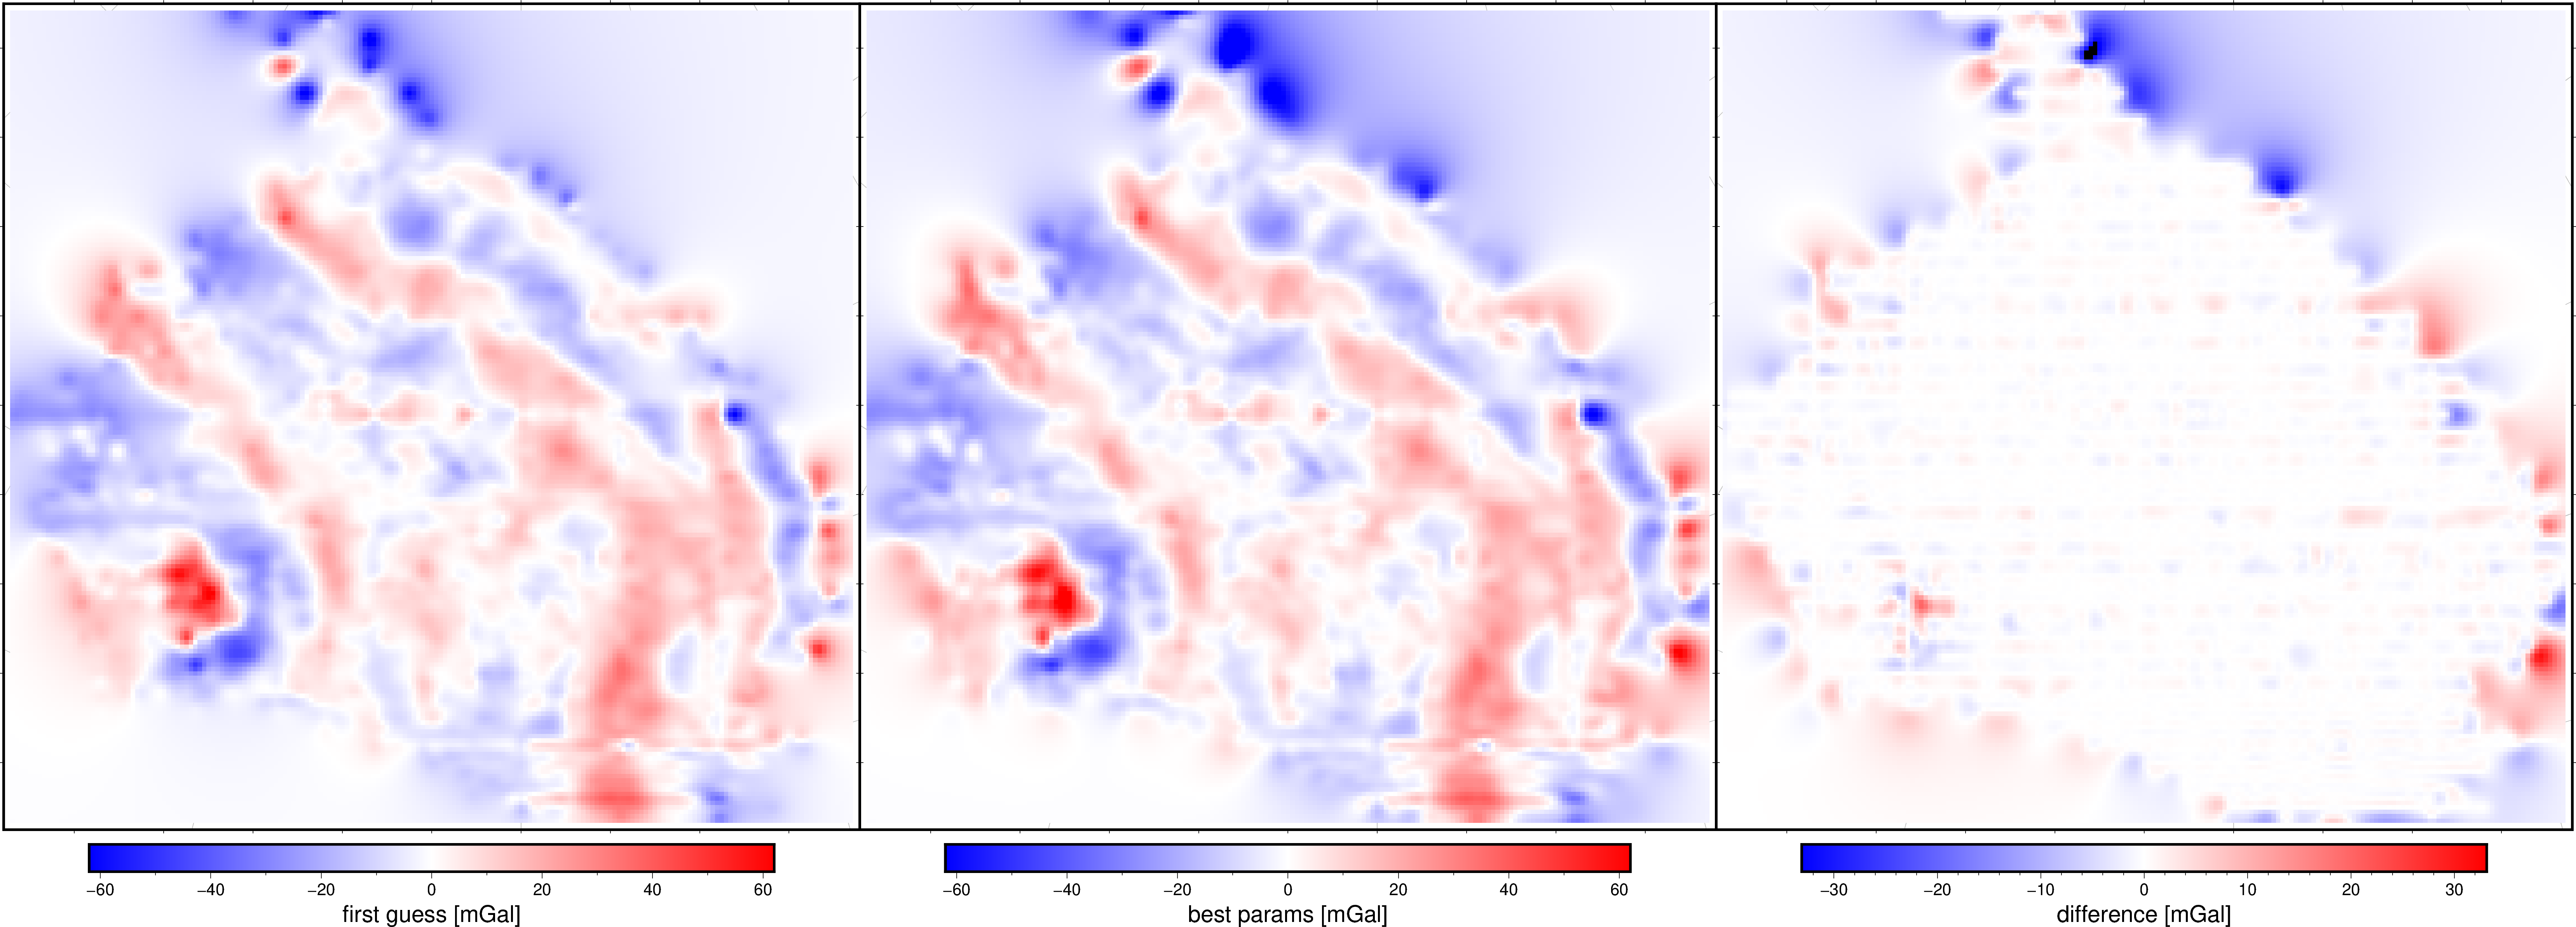

In [15]:
start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y))
maxabs = vd.maxabs(grid_first_guess.scalars)*.9
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs], background=True)  
fig.grdimage(grid=grid_first_guess.scalars, cmap=True)
fig.colorbar(frame='af+l"first guess [mGal]"')

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True) 
fig.grdimage(grid=grid.scalars, cmap=True)
fig.colorbar(frame='af+l"best params [mGal]"')

dif = grid.scalars - grid_first_guess.scalars
start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True) 
maxabs = vd.maxabs(dif)*.9
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs])  
fig.grdimage(grid=dif, cmap=True)
fig.colorbar(frame='af+l"difference [mGal]"')

fig.show()

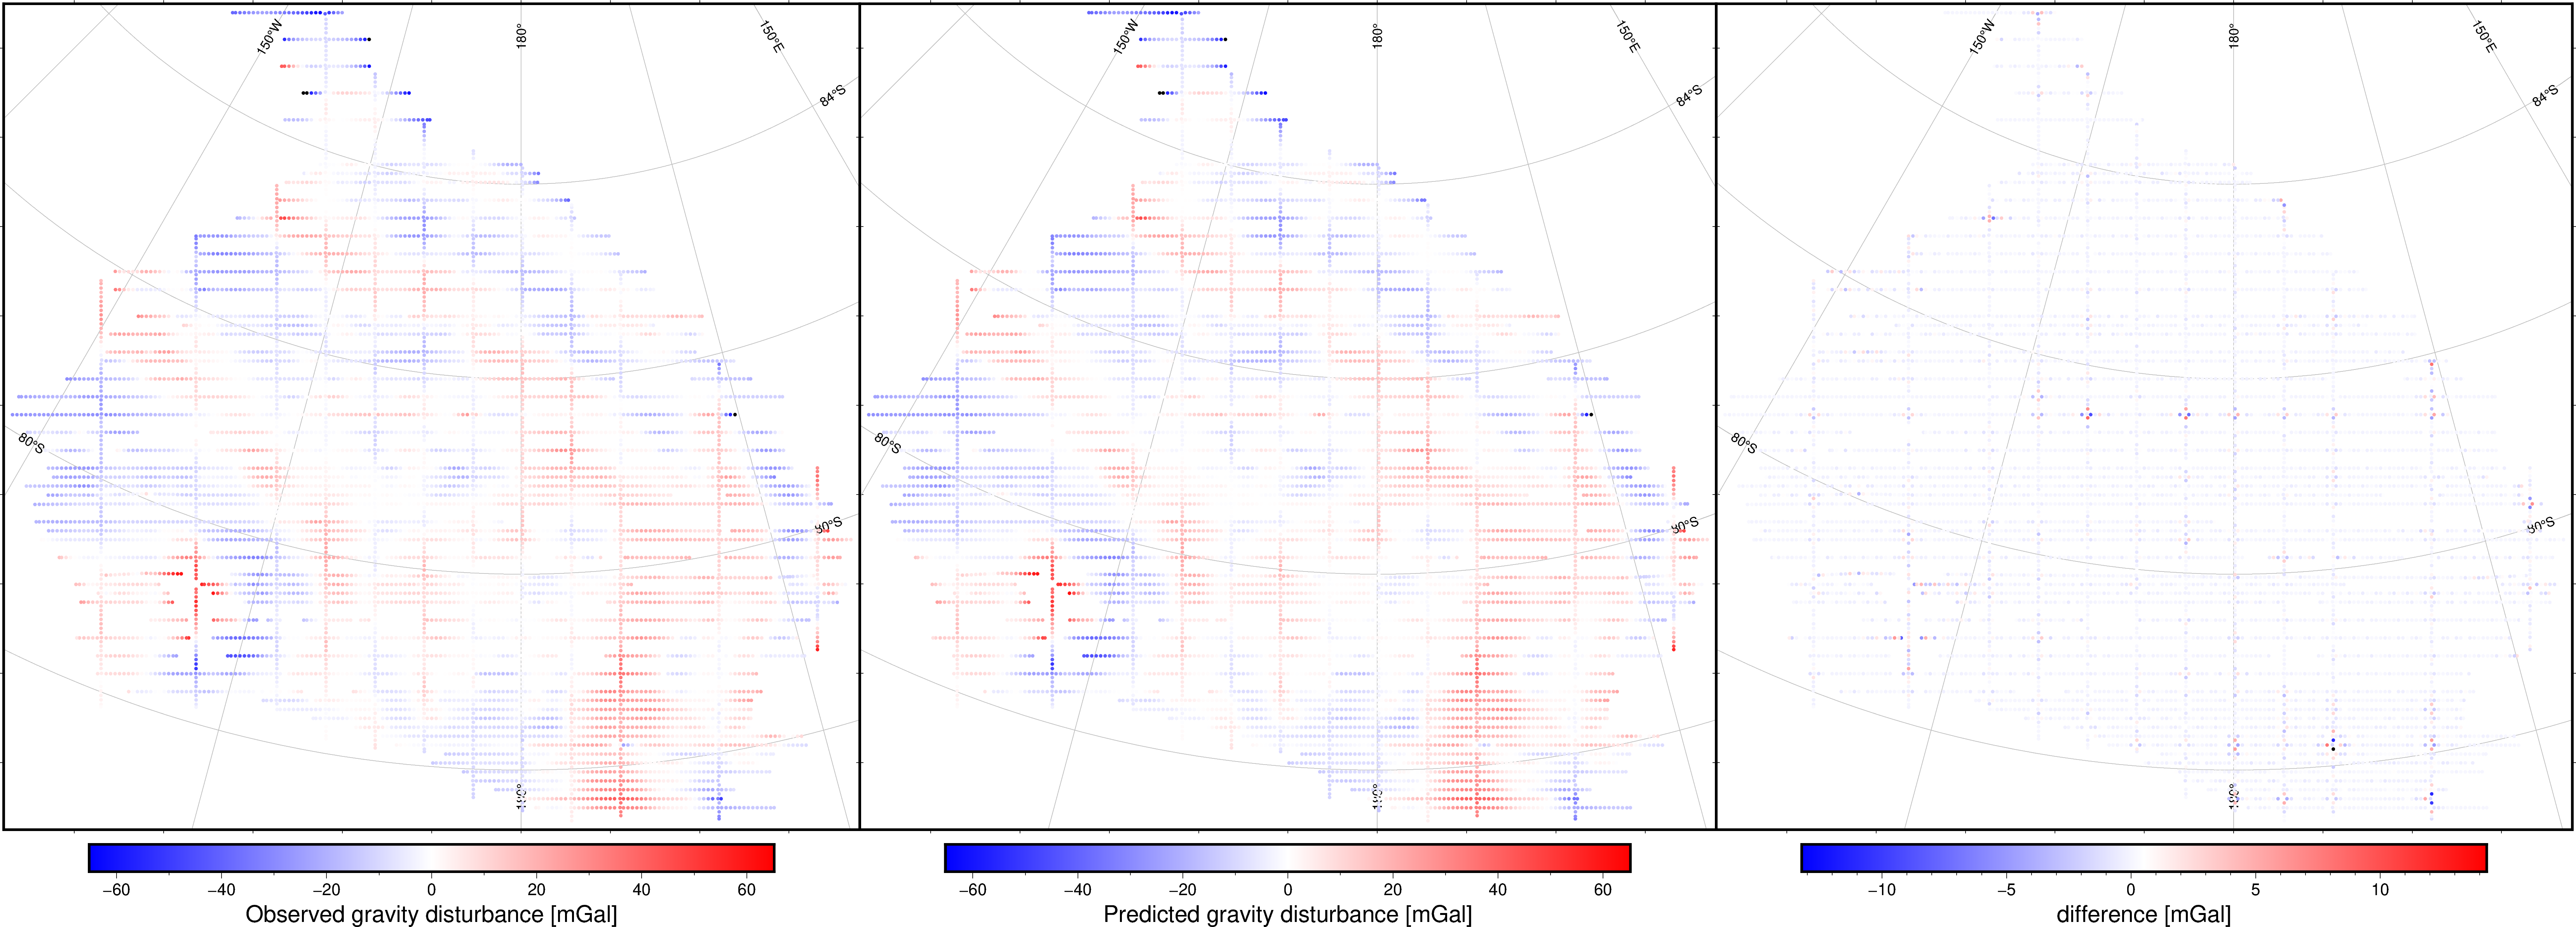

<AxesSubplot:>

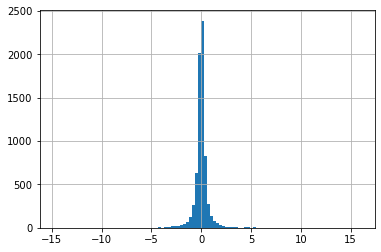

In [16]:
start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y))
maxabs = vd.maxabs(df_cleaned.FAG_levelled)*.9
pygmt.makecpt(cmap="polar", series=[-maxabs,maxabs])  
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=df_cleaned.FAG_levelled,
         style='c2p',
         cmap=True)
fig.colorbar(frame='af+l"Observed gravity disturbance [mGal]"')

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True) 
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=df_cleaned.best_disturbance,
         style='c2p', 
         cmap=True)
fig.colorbar(frame='af+l"Predicted gravity disturbance [mGal]"')

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True) 
dif = df_cleaned.best_disturbance-df_cleaned.FAG_levelled
pygmt.makecpt(cmap="polar", series=[dif.min()*.9,dif.max()*.9])  
fig.plot(x=df_cleaned.x, 
         y=df_cleaned.y, 
         color=dif,
         style='c2p', 
         cmap=True)
fig.colorbar(frame='af+l"difference [mGal]"')

fig.show()
dif.hist(bins=100)

## compare upward continue amounts

1374.9334565217391

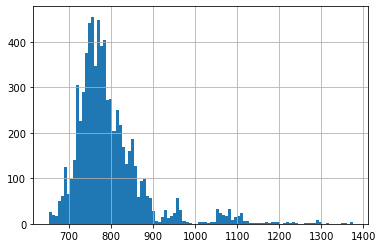

In [17]:
df_cleaned.elev.hist(bins=100)
df_cleaned.elev.max()

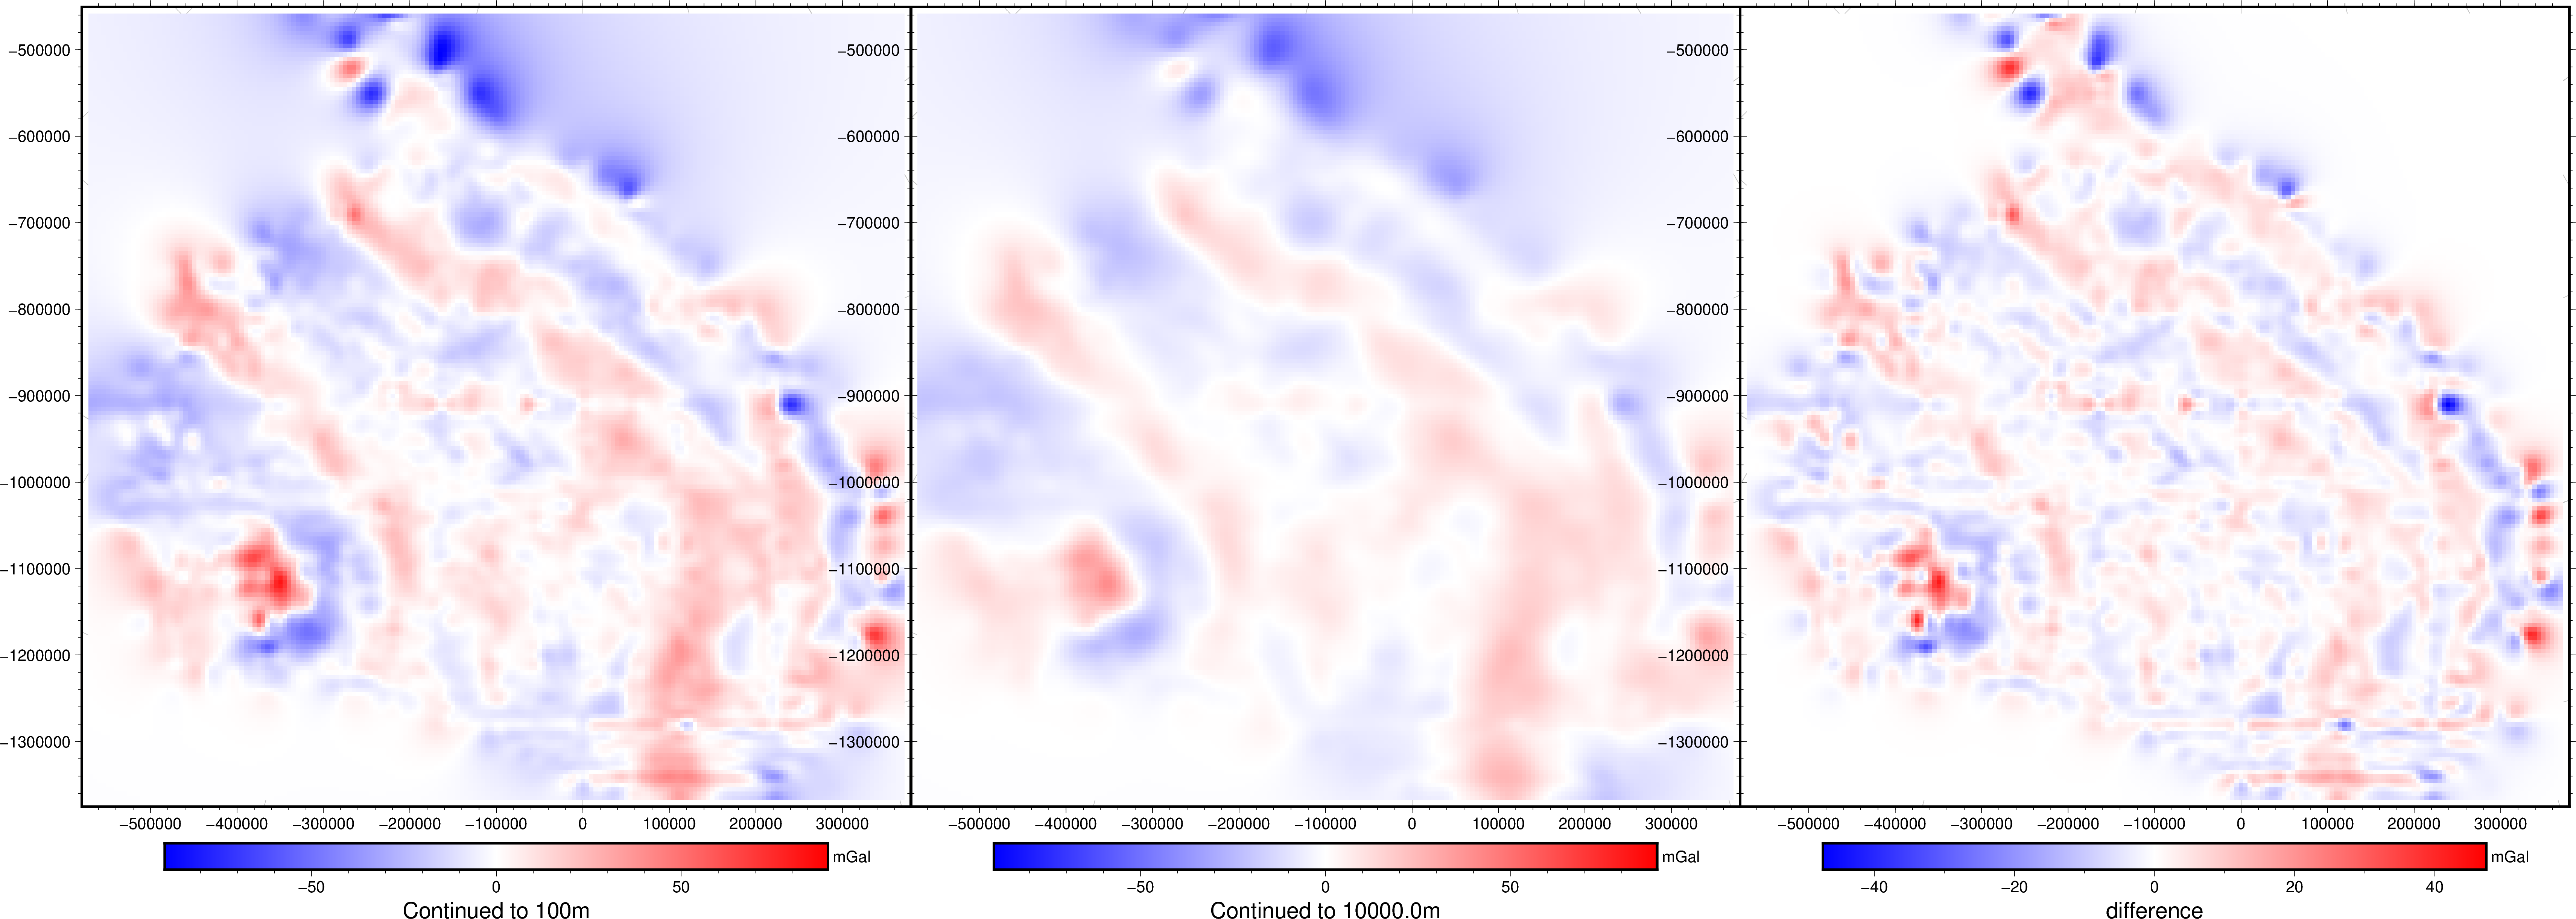

In [18]:
# Build the grid coordinates
region = vd.get_region(coordinates)

low=100
grid_coords_low = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=low)
high=10e3
grid_coords_high = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=high)

# Grid the gravity disturbances
grid_low = eqs_best.grid(grid_coords_low, data_names=["gravity_disturbance"])
grid_high = eqs_best.grid(grid_coords_high, data_names=["gravity_disturbance"])

diff = grid_low.gravity_disturbance - grid_high.gravity_disturbance
grid = diff

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y)) 
grid = grid_low.gravity_disturbance
maxabs = vd.maxabs(grid)
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
fig.grdimage(
   frame=['af', 'WSen'],
   grid=grid,
   cmap=True,)
fig.colorbar(cmap=True, frame=[f"x+lContinued to {low}m", "y+lmGal"])

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True)
grid = grid_high.gravity_disturbance 
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
fig.grdimage(
   frame=['af', 'WSen'],
   grid=grid,
   cmap=True,)
fig.colorbar(cmap=True, frame=[f"x+lContinued to {high}m", "y+lmGal"])

start_fig(data_region=True, coordinates=(df_cleaned.x, df_cleaned.y), subplots=True) 
grid = diff
maxabs = vd.maxabs(grid)
pygmt.makecpt(cmap="polar+h0", series=[-maxabs, maxabs])
fig.grdimage(
   frame=['af', 'WSen'],
   grid=grid,
   cmap=True,)
fig.colorbar(cmap=True, frame=["x+ldifference", "y+lmGal"])

fig.show()

# mask grid

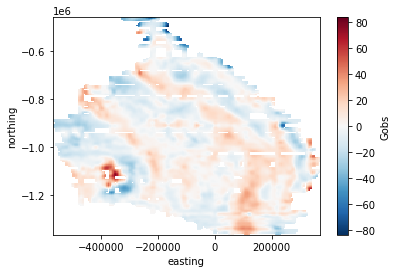

In [19]:
up_con_elev = 1e3
grid_coords = vd.grid_coordinates(region=region, spacing=5e3, extra_coords=up_con_elev)

# Grid the gravity disturbances
grid = eqs_best.grid(grid_coords, data_names=["Gobs"])
masked = vd.distance_mask((df_cleaned.x, df_cleaned.y), maxdist=10e3, grid=grid)
masked['height']=masked.upward
masked.Gobs.plot()

# save as netcdf

: Title: 
: Command: 
: Remark: 
: Gridline node registration used [Cartesian grid]
: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7
: x_min: -569306.933744 x_max: 369269.342582 x_inc: 4992.42700173 name: x n_columns: 189
: y_min: -1365285.60916 y_max: -460457.076 y_inc: 4999.0526694 name: y n_rows: 182
: v_min: 1000 v_max: 1000 name: z
: scale_factor: 1 add_offset: 0
: format: classic



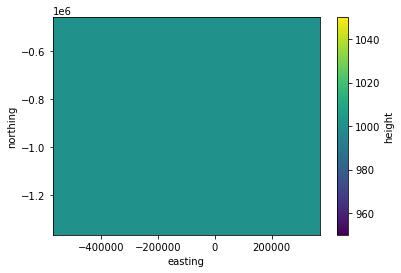

In [20]:
masked.height.plot()
print(pygmt.grdinfo(masked.height))

: Title: 
: Command: 
: Remark: 
: Gridline node registration used [Cartesian grid]
: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7
: x_min: -569306.933744 x_max: 369269.342582 x_inc: 4992.42700173 name: x n_columns: 189
: y_min: -1365285.60916 y_max: -460457.076 y_inc: 4999.0526694 name: y n_rows: 182
: v_min: -83.5841751099 v_max: 76.3608627319 name: z
: scale_factor: 1 add_offset: 0
: format: classic



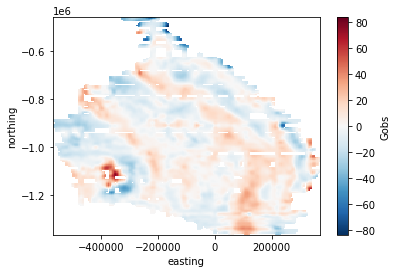

In [21]:
masked.Gobs.plot()
print(pygmt.grdinfo(masked.Gobs))

In [22]:
# grid = xr.Dataset()
pygmt.grdsample(
            grid=masked.height,
            region=[-580000, 420000, -1420000, -420000], 
            registration='p', 
            spacing="5000+e",
            outgrid='gravity_data/rosetta_eq_source_up_continued_elev.nc') 
pygmt.grdsample(
            grid=masked.Gobs,
            region=[-580000, 420000, -1420000, -420000], 
            registration='p', 
            spacing="5000+e",
            outgrid='gravity_data/rosetta_eq_source_up_continued_Gobs.nc') 
# grid.to_netcdf('gravity_data/rosetta_eq_source_up_continued_gridline.nc')

print(pygmt.grdinfo('gravity_data/rosetta_eq_source_up_continued_elev.nc'))

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


gravity_data/rosetta_eq_source_up_continued_elev.nc: Title: z
gravity_data/rosetta_eq_source_up_continued_elev.nc: Command: grdsample @GMTAPI@-S-I-G-M-G-N-000000 -Ggravity_data/rosetta_eq_source_up_continued_elev.nc -I5000+e -R-580000/420000/-1420000/-420000 -rp
gravity_data/rosetta_eq_source_up_continued_elev.nc: Remark: 
gravity_data/rosetta_eq_source_up_continued_elev.nc: Pixel node registration used [Cartesian grid]
gravity_data/rosetta_eq_source_up_continued_elev.nc: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7
gravity_data/rosetta_eq_source_up_continued_elev.nc: x_min: -565000 x_max: 365000 x_inc: 5000 name: x n_columns: 186
gravity_data/rosetta_eq_source_up_continued_elev.nc: y_min: -1365000 y_max: -465000 y_inc: 5000 name: y n_rows: 180
gravity_data/rosetta_eq_source_up_continued_elev.nc: v_min: 1000 v_max: 1000 name: z
gravity_data/rosetta_eq_source_up_continued_elev.nc: scale_factor: 1 add_offset: 0
gravity_data/rosetta_eq_source_up_continued_elev.nc: forma

In [23]:
up_con_elev=1e3
grav = xr.load_dataarray('gravity_data/rosetta_eq_source_up_continued_Gobs.nc')
df = vd.grid_to_table(grav)
df.rename(columns={'z':'Gobs'}, inplace=True)

# elev = xr.load_dataarray('gravity_data/rosetta_eq_source_up_continued_elev.nc')
# df1 = vd.grid_to_table(elev)

df['z'] = up_con_elev
df.dropna(inplace=True)
df = df[['x','y','Gobs','z']]
df.to_csv('gravity_data/rosetta_eq_source_up_continued.csv', index=False)
df.describe()


x             y          Gobs        z
count   19666.000000  1.966600e+04  19666.000000  19666.0
mean   -93661.903793 -9.902100e+05     -0.248083   1000.0
std    223211.973413  1.971037e+05     13.005807      0.0
min   -562500.000000 -1.362500e+06    -83.122131   1000.0
25%   -262500.000000 -1.147500e+06     -7.901796   1000.0
50%    -92500.000000 -1.002500e+06     -0.095627   1000.0
75%     82500.000000 -8.475000e+05      7.546713   1000.0
max    362500.000000 -4.675000e+05     75.122253   1000.0

In [24]:
df=pd.read_csv('gravity_data/rosetta_eq_source_up_continued.csv', index_col=False)
df

x          y       Gobs       z
0       -2500.0 -1362500.0 -13.700118  1000.0
1        2500.0 -1362500.0 -14.224596  1000.0
2       17500.0 -1362500.0  -8.105549  1000.0
3       22500.0 -1362500.0  -9.038119  1000.0
4       27500.0 -1362500.0 -11.456600  1000.0
...         ...        ...        ...     ...
19661 -217500.0  -467500.0 -15.469933  1000.0
19662 -212500.0  -467500.0 -13.597374  1000.0
19663 -207500.0  -467500.0 -13.328206  1000.0
19664 -202500.0  -467500.0 -12.510348  1000.0
19665 -197500.0  -467500.0 -13.062867  1000.0

[19666 rows x 4 columns]

In [36]:
df['Gobs'] -= df.Gobs.mean()
df.describe()

x             y          Gobs        z
count   19666.000000  1.966600e+04  1.966600e+04  19666.0
mean   -93661.903793 -9.902100e+05 -3.699765e-16   1000.0
std    223211.973413  1.971037e+05  1.300581e+01      0.0
min   -562500.000000 -1.362500e+06 -8.287405e+01   1000.0
25%   -262500.000000 -1.147500e+06 -7.653712e+00   1000.0
50%    -92500.000000 -1.002500e+06  1.524566e-01   1000.0
75%     82500.000000 -8.475000e+05  7.794796e+00   1000.0
max    362500.000000 -4.675000e+05  7.537033e+01   1000.0

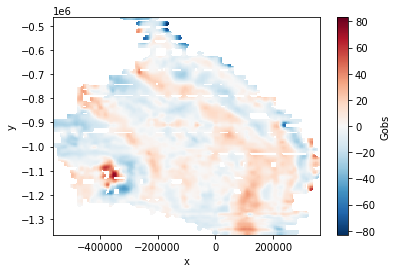

In [41]:
df.set_index(['y','x']).to_xarray().Gobs.plot()

# Gridding without Eq_Sources

In [15]:
rosetta_block = pygmt.blockmedian(data=rosetta[["x", "y", "FA"]], 
                                         spacing="1000", 
                                         region=fig_reg)
pygmt.surface(data=rosetta_block,
              spacing='1000', M='10c', registration='p',
              region=fig_reg, outgrid='gravity_data/rosetta_grav.nc') 
rosetta_grid = xr.load_dataarray('gravity_data/rosetta_grav.nc')

rosetta_block_height = pygmt.blockmedian(data=rosetta[["x", "y", "Height"]], 
                                         spacing="1000", 
                                         region=fig_reg)
pygmt.surface(data=rosetta_block_height,
              spacing='1000', M='10c', registration='p',
              region=fig_reg, outgrid='gravity_data/rosetta_height.nc') 
rosetta_height = xr.load_dataarray('gravity_data/rosetta_height.nc')

# !gmt grdmask ..\shapefiles\RIS_outline.shp -GRIS_mask.nc -I5000+e -R-760000/600000/-1600000/-350000 -NNaN/1/1
# !gmt grdmath -Df layers/ROSETTA_gravity.nc RIS_mask.nc MUL = layers/ROSETTA_gravity.nc
# !gmt grdsample layers/ROSETTA_gravity.nc -Glayers/ROSETTA_gravity.nc -T
print(f'{len(rosetta.FA)=}')
print(f'{len(rosetta_block)=}')
print(f'{len(rosetta_grid)=}')

surface [WARNING]: 6564 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.
surface [WARNING]: 6564 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


len(rosetta.FA)=398279
len(rosetta_block)=37401
len(rosetta_grid)=1400


In [15]:
rosetta = xr.load_dataset('gravity_data/rosetta_grav.nc')
rosetta = rosetta.rename({'z':'Gobs'})
height = xr.load_dataarray('gravity_data/rosetta_height.nc')
rosetta['height'] = height
rosetta.to_netcdf('gravity_data/rosetta.nc')

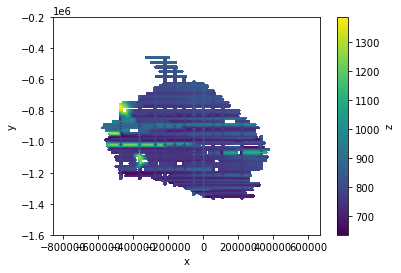

In [17]:
grid = xr.load_dataset('gravity_data/rosetta.nc')
grid.height.plot()

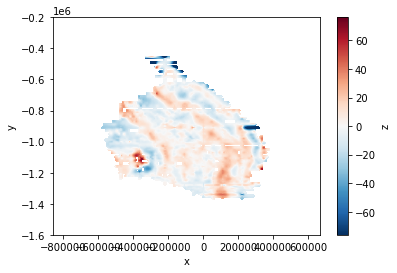

In [29]:
rosetta_grid -= rosetta_grid.mean().item()
# rosetta_grid.plot.hist(bins=100)
rosetta_grid.clip(min=-75).plot.hist(bins=100)
rosetta_grid.clip(min=-75).plot()
rosetta_grid.clip(min=-75).to_netcdf('gravity_data/rosetta_grav.nc')

(array([5.3100e+02, 2.0000e+00, 3.0000e+00, 1.0000e+01, 4.0000e+00,
        5.0000e+00, 1.2000e+01, 3.1000e+01, 3.5000e+01, 2.4000e+01,
        2.3000e+01, 2.3000e+01, 2.5000e+01, 2.6000e+01, 3.0000e+01,
        4.2000e+01, 3.1000e+01, 4.6000e+01, 3.2000e+01, 4.8000e+01,
        4.2000e+01, 4.4000e+01, 4.7000e+01, 6.4000e+01, 7.4000e+01,
        6.8000e+01, 6.1000e+01, 6.1000e+01, 2.1900e+02, 2.7700e+02,
        2.3700e+02, 2.2700e+02, 2.2100e+02, 2.2600e+02, 2.0800e+02,
        1.7500e+02, 2.2200e+02, 1.8000e+02, 2.0300e+02, 2.3600e+02,
        2.0900e+02, 2.3900e+02, 2.4800e+02, 2.6900e+02, 2.5900e+02,
        3.0700e+02, 2.9400e+02, 3.9200e+02, 5.9800e+02, 6.2400e+02,
        6.7100e+02, 7.8700e+02, 7.5100e+02, 7.9100e+02, 1.2880e+03,
        2.6510e+03, 4.5060e+03, 6.0450e+03, 6.7220e+03, 8.5870e+03,
        1.2203e+04, 1.5798e+04, 1.8846e+04, 2.5617e+04, 3.3403e+04,
        3.4264e+04, 3.8254e+04, 4.1585e+04, 4.5360e+04, 4.0423e+04,
        3.1007e+04, 2.8611e+04, 2.5324e+04, 1.84

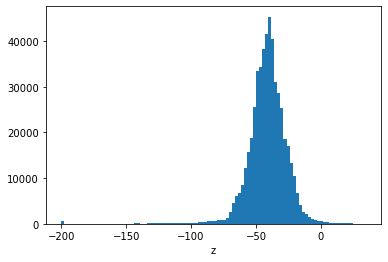

In [13]:
# initialize figure but extend plot north into Ross Sea
# start_fig(n = -2200e3)

# start_fig()

# make color ramp scaled to points
# pygmt.grd2cpt(cmap="jet", grid=rosetta_grid)

# # plot grid
# fig.grdimage(projection = fig_proj,
#              grid=rosetta_grid,
#              cmap=True, nan_transparent=True)

# # colorbar
# with pygmt.config(FONT_ANNOT_PRIMARY = '18p,black', FONT_LABEL = '20p,black'):
#     fig.colorbar(cmap=True, position = pos_str, 
#                  frame=['xa100f100+l"FA gravity (mGal)"'], verbose='e')     

# fig.show() 

# Updated AntGG compilation

In [3]:
# forsberg compilation
# includes AngGG, DTU Space, PolarGap, OIB,a ROSETTA, GOCE
# FA is free-air anom at geioid, DG is disturbance (FA at ellipsoid), BA is bouguer anom (free air at sea) 
# antgg_update_tif = rioxarray.open_rasterio('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_fa.tif')
# file ='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/ant4d_gravity.dat'
file='/Volumes/arc_04/tankerma/Datasets/4D_antarctica_grav/ant4d_gravity/ant4d_gravity.dat'
antgg_update = pd.read_csv(file, delim_whitespace=True, 
                           skiprows=3, names=['id', 'lat', 'lon', 'FA', 'Err', 'DG', 'BA'])

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
antgg_update['x'], antgg_update['y'] = transformer.transform(antgg_update.lat.tolist(), antgg_update.lon.tolist())

region = vd.get_region((antgg_update.x, antgg_update.y))
antgg_update.describe()

id            lat            lon             FA  \
count  348276.000000  348276.000000  348276.000000  348276.000000   
mean   222439.400160     -69.840288      -0.192563      -2.697175   
std    111064.684586       7.034158     103.925276      27.980076   
min       311.000000     -89.907960    -180.000000    -237.560000   
25%    132748.250000     -74.768500     -90.181455     -18.940000   
50%    222442.500000     -68.570830      -0.190035      -3.320000   
75%    312122.250000     -63.897150      89.816508      12.060000   
max    444579.000000     -59.954690     179.827940     171.860000   

                 Err             DG             BA             x             y  
count  348276.000000  348276.000000  348276.000000  3.482760e+05  3.482760e+05  
mean        3.548024       1.488909     -32.612559 -3.633612e+02  8.344000e+01  
std         3.112447      25.843419      60.363350  1.665051e+06  1.665136e+06  
min         0.800000    -219.150000    -406.410000 -3.330001e+06 -3.330001e+06  
25%         2.300000     -13.190000     -53.010000 -1.350000e+06 -1.340001e+06  
50%         3.000000       0.590000     -11.620000 -3.980099e-11  1.031765e-10  
75%         3.100000      15.040000       5.210000  1.340000e+06  1.342500e+06  
max        20.600000     178.030000     164.610000  3.330001e+06  3.330001e+06

In [6]:
antgg_update = pygmt.blockmedian(antgg_update[["x", "y", "FA"]], 
                                         spacing="5000+e", 
                                         region=(-3330000, 3330000, -3330000, 3330000))

# antgg_update = antgg_update.set_index(['x', 'y'])

# antgg_update=antgg_update[~antgg_update.index.duplicated()]
# # # antgg_update.to_xarray()
# xr.Dataset.from_dataframe(antgg_update)

fname = 'gravity_data/ant4d_gravity_epsg_5k.nc'
pygmt.surface(data=antgg_update[['x','y','FA']], 
                            spacing=5000, 
                            region=(-3330000, 3330000, -3330000, 3330000),
                            M='2c',
                            outgrid=fname
                            )
# antgg_update_tif
# pygmt.grdfill(grid=antgg_update_grid, mode='n', L=True, region=fig_reg)#, outgrid=fname)

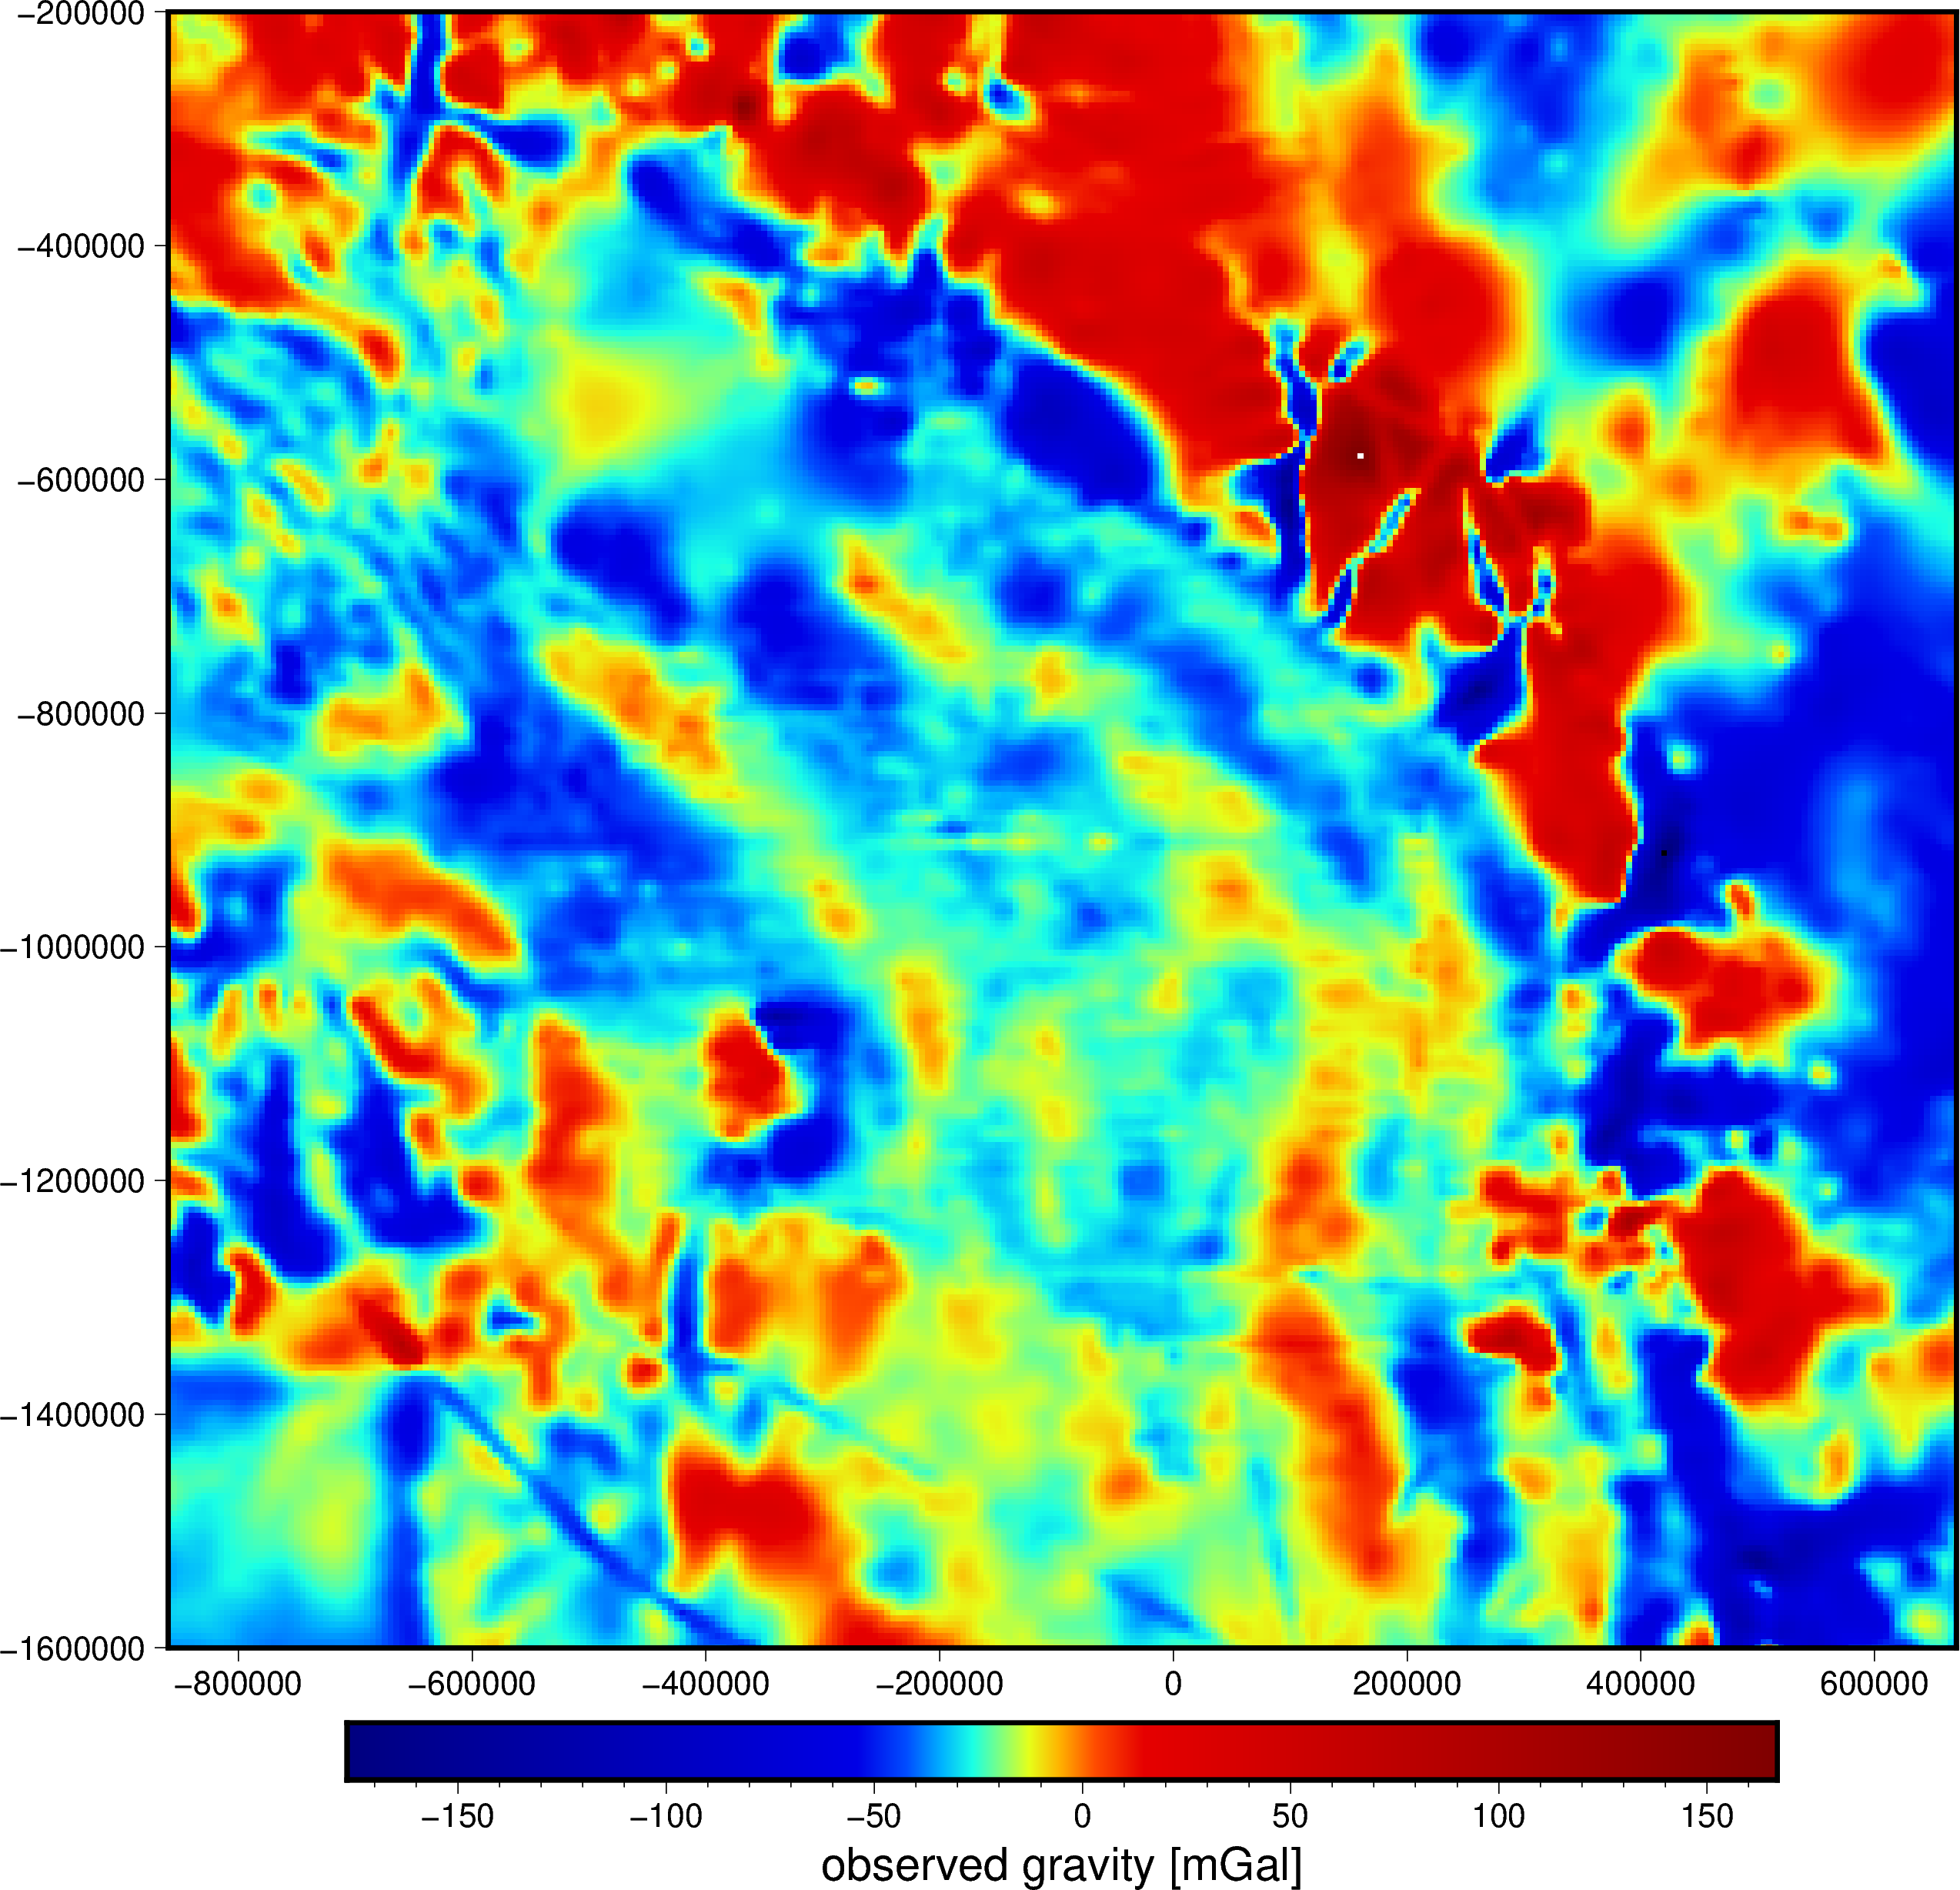

In [9]:
start_fig()
fname = '/Volumes/arc_04/tankerma/Datasets/4D_antarctica_grav/ant4d_gravity/ant4d_gravity_epsg_5k.nc'
# make color ramp scaled to points
pygmt.grd2cpt(cmap="jet", continuous=True, region=fig_reg, grid=fname)
# pygmt.makecpt(cmap="viridis", series=[antgg_update.FA.min(), antgg_update.FA.max()])

# plot grid      
fig.grdimage(grid=fname,
    cmap=True,
    projection=fig_proj, 
    region=fig_reg,
    frame=['a','+gwhite'],)

fig.colorbar(frame='af+l"observed gravity [mGal]"')

fig.show() 

# Ground Surveys

In [ ]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/K863_KIS.csv'
KIS = pd.read_csv(file)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
KIS['x'], KIS['y'] = transformer.transform(KIS.Latitude.tolist(), KIS.Longitude.tolist())

KIS

In [ ]:
df=KIS
buffer=10e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

KIS['FA_shift']=KIS.FA+(df.FA.mean()-KIS.FA.mean())

In [ ]:
df=KIS
buffer=80e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

start_fig(n=n, s=s, e=e, w=w)


df=KIS
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 

In [ ]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/K863_DD_2feb22.csv'
DD = pd.read_csv(file)
DD.drop(columns=['Free air anomaly', 'Free air effect'], inplace=True)
DD['FA']=DD['Absolute Gravity']-DD['Ellipsoidal gravity']+(DD.Elevation*0.3086)

transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
DD['x'], DD['y'] = transformer.transform(DD.Latitude.tolist(), DD.Longitude.tolist())
DD

In [ ]:
df=DD
buffer=10e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

DD['FA_shift']=DD.FA+(df.FA.mean()-DD.FA.mean())

start_fig(n=n, s=s, e=e, w=w)


df=DD
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 

In [ ]:
fig_reg

In [ ]:
file='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/gravity_data/wgz_fa.csv'
WGZ = pd.read_csv(file)
WGZ.rename(columns={'free-air_disturbance(mGal)':'FA', 'PSX(m)':'x', 'PSY(m)':'y'}, inplace=True)
# transformer = Transformer.from_crs("epsg:4326", "epsg:3031")
# WGZ['x'], WGZ['y'] = transformer.transform(WGZ.Latitude.tolist(), WGZ.Longitude.tolist())
WGZ

In [ ]:
df=WGZ
buffer=20e3
n=df.y.min()-buffer
s=df.y.max()+buffer
e=df.x.min()-buffer
w=df.x.max()+buffer

df=rosetta_block
df = df[df.y.between(n, s) & df.x.between(e, w)]

WGZ['FA_shift']=WGZ.FA+(df.FA.mean()-WGZ.FA.mean())

start_fig(n=n, s=s, e=e, w=w)


df=WGZ
# make color ramp scaled to points
pygmt.makecpt(cmap="jet", series=[df.FA_shift.min(), df.FA_shift.max()], background=True)

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA_shift,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

df=rosetta_block

# plot points
fig.plot(x=df.x, 
         y=df.y, 
         color=df.FA,
         style='c4p',
         projection = fig_proj,
         region=fig_reg, 
         cmap=True)

fig.colorbar(frame='af+l"FA gravity (mGal)"')

fig.show() 